# Temat: Określenie czy dana osoba zarabia więcej niż 50tyś dolarów rocznie.

Autorzy: Mariusz Rebandel, Jakub Typiński

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
adult = pd.read_csv("adult.csv")

## 1. Omówienie tematu

Badamy dane dotyczące zarobków w Ameryce w roku 1994. Później się tu coś dopisze.

## 2. Wstępne przygotowanie danych

### 2.1 Uzupełnienie i usunięcie pustych danych

Poniżej znajduje się skrypt badający wypełnienie poszczególnych kolumn

Rozmiar: 32561 wierszy.


/home/mariusz/anaconda2/lib/python2.7/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


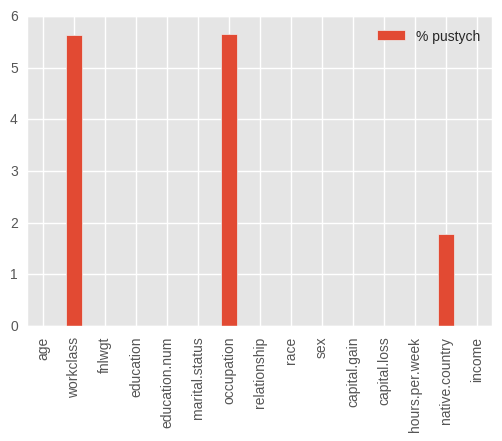

In [2]:
size = len(adult)
print "Rozmiar:", size, "wierszy."
frame = pd.DataFrame(index = adult.columns)
for col in adult.columns:
    empty = 0
    try:
        empty = len(adult.loc[adult[col] == '?'])
    except:
        empty = len(adult.loc[adult[col] == np.NaN])
    percentage = float(empty)*100.0/float(size)
    frame.set_value(col, '% pustych', percentage)
frame.transpose()
frame.plot(kind='bar')

Jak widać, jedynymi kolumnami posiadającymi puste pola są te określające segment rynku, zawód i kraj pochodzenia. Ponadto widać podobną ilość pustych pól w kategoriach segmentu rynku i zatrudnienia, co każe sądzić że są w jakiś sposób ze sobą skorelowane.

In [3]:
dat = [len(adult.loc[adult['workclass'] == '?']), len(adult.loc[adult['occupation'] == '?']),
     len(adult.loc[adult['workclass'] == '?'].loc[adult['occupation'] == '?'])]
ind = ["Segment rynku", "Zawód", "Obydwa"]
pd.DataFrame(index=ind, data=dat, columns=['Nie podano razy'])

,Nie podano razy
Segment rynku,1836
Zawód,1843
Obydwa,1836


Jak widać w każdym wypadku nie podania segmentu rynku badany nie podawał także uprawianego zawodu. Poniżej znajduje się analiza ilości niezatrudnionych osób względem wieku.

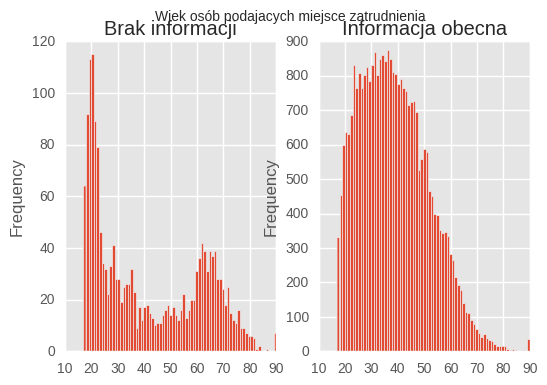

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
df1 = adult.loc[adult['workclass'] == '?'].loc[adult['occupation'] == '?'].sort_values(by=['age'])
dfh1 = df1['age'].plot.hist(bins=(90-16), title = 'Brak informacji', ax=ax1)
df2 = adult.loc[adult['workclass'] != '?'].loc[adult['occupation'] != '?'].sort_values(by=['age'])
dfh2 = df2['age'].plot.hist(bins=(90-16), title = 'Informacja obecna', ax=ax2)
fig.suptitle(u"Wiek osób podajacych miejsce zatrudnienia")


Na powyższym wykresie widać duży odsetek osób niezatrudnionych w wieku ok. 20 lat i osób po 60 roku życia. Każe to sądzić, że osoby w wieku 20 lat jeszcze się uczą, natomiast z opracowań statystycznych wynika, że w latach 90. przeciętna wieku przejścia na emeryturę w Ameryce wynosiła 62 lata, zarówno dla kobiet jak i mężczyzn, co potwierdza przypuszczenia, że osoby niepodające zatrudnienia po 60 roku życia to emeryci. Oznacza to, że nie podanie zatrudnienia to brak pracy. Można zauważyć inny rozkład na wykresie z osobami podającymi miejsce zatrudnienia. Dlatego osobom posiadającym znak '?' przypisujemy wartość 'None' oznaczającą aktualny brak zatrudnienia.

In [5]:
adult = adult.drop(adult.loc[adult["occupation"] == '?'].loc[adult["workclass"] != '?'].index)
adult['occupation'] = adult['occupation'].replace(to_replace='?', value='None')
adult['workclass'] = adult['workclass'].replace(to_replace='?', value='None')

Usuwamy wszystkie wiersze, gdzie wprowadzono segment rynku, a nie wprowadzono zawodu. Jest ich znikoma liczba, więc nie wpłynie to znacząco na wyniki badań.

Pozostała kwestia narodowości. Uzupełnione zostaną one najczęściej występującym krajem pochodzenia osób tej samej rasy.

In [6]:
mcc = {}; "Najczęstsze kraje pochodzenia"
for x in adult["race"].unique():
    series = adult.loc[adult["race"] == x]["native.country"]
    counts = series.value_counts()
    mcc[x] = counts.index[0]
    print u"Najczęstszy kraj rasy",x,":",counts.index[0],"(",counts.max(),"/",counts.sum(),")"

Najczęstszy kraj rasy White : United-States ( 25616 / 27811 )
Najczęstszy kraj rasy Black : United-States ( 2830 / 3122 )
Najczęstszy kraj rasy Asian-Pac-Islander : United-States ( 292 / 1039 )
Najczęstszy kraj rasy Other : United-States ( 129 / 271 )
Najczęstszy kraj rasy Amer-Indian-Eskimo : United-States ( 296 / 311 )


In [7]:
for x in mcc.keys():
    adult.loc[(adult["race"] == x) & (adult["native.country"] == "?"), "native.country" ] = mcc[x]

Po zastąpieniu najczęstszymi krajami pochodzenia ludzi różnych ras są:

In [8]:
for x in adult["race"].unique():
    series = adult.loc[adult["race"] == x]["native.country"]
    counts = series.value_counts()
    print u"Najczęstszy kraj rasy",x,":",counts.index[0],"(",counts.max(),"/",counts.sum(),")"

Najczęstszy kraj rasy White : United-States ( 26002 / 27811 )
Najczęstszy kraj rasy Black : United-States ( 2926 / 3122 )
Najczęstszy kraj rasy Asian-Pac-Islander : United-States ( 375 / 1039 )
Najczęstszy kraj rasy Other : United-States ( 147 / 271 )
Najczęstszy kraj rasy Amer-Indian-Eskimo : United-States ( 296 / 311 )


## 2.2 Usunięcie zbędnych kolumn

In [9]:
del adult["fnlwgt"]

## 2.3 Zgrupowanie danych

In [10]:
adult["native.country"].value_counts()

United-States                 29746
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [11]:
countries = {
    'United-States' : 'North America',
    'Mexico'        : 'South America',
    'Philippines'   : 'Asia',
    'Germany'       : 'Europe',
    'Canada'        : 'North America',
    'Puerto-Rico'   : 'South America',
    'El-Salvador'   : 'South America',
    'India'         : 'Asia',
    'Cuba'          : 'South America',
    'England'       : 'Europe',
    'Jamaica'       : 'South America',
    'South'         : 'South America',
    'China'         : 'Asia',
    'Italy'         : 'Europe',
    'Dominican-Republic' : 'South America',
    'Vietnam'       : 'Asia',
    'Guatemala'     : 'South America',
    'Japan'         : 'Asia',
    'Poland'        : 'Europe',
    'San Escobar'   : 'South America',
    'Columbia'      : 'South America',
    'Taiwan'        : 'Asia',
    'Haiti'         : 'South America',
    'Iran'          : 'Asia',
    'Portugal'      : 'Europe',
    'Nicaragua'     : 'South America',
    'Peru'          : 'South America',
    'France'        : 'Europe',
    'Greece'        : 'Europe',
    'Ecuador'       : 'South America',
    'Ireland'       : 'Europe',
    'Hong'          : 'Asia',
    'Trinadad&Tobago':'South America',
    'Cambodia'      : 'Asia',
    'Laos'          : 'Asia',
    'Thailand'      : 'Asia',
    'Yugoslavia'    : 'Europe',
    'Outlying-US(Guam-USVI-etc)':'North America',
    'Hungary'       : 'Europe',
    'Honduras'      : 'South America',
    'Scotland'      : 'Europe',
    'Holand-Netherlands': 'Europe'
}

for x in countries.keys():
    adult.loc[adult["native.country"] == x, "native.country"] = countries[x]

In [12]:
adult['native.country'].value_counts()

North America    29881
South America     1481
Asia               671
Europe             521
Name: native.country, dtype: int64

# 3. Analiza danych

## 3.1 Procentowy skład grup społecznych zarabiających powyżej 50 tysięcy dolarów

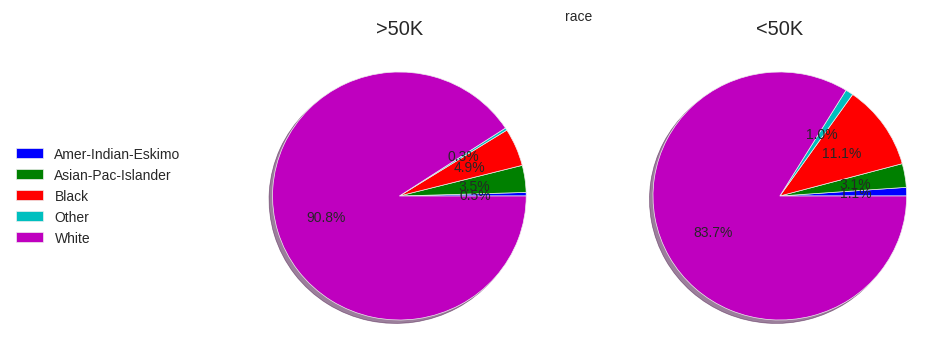

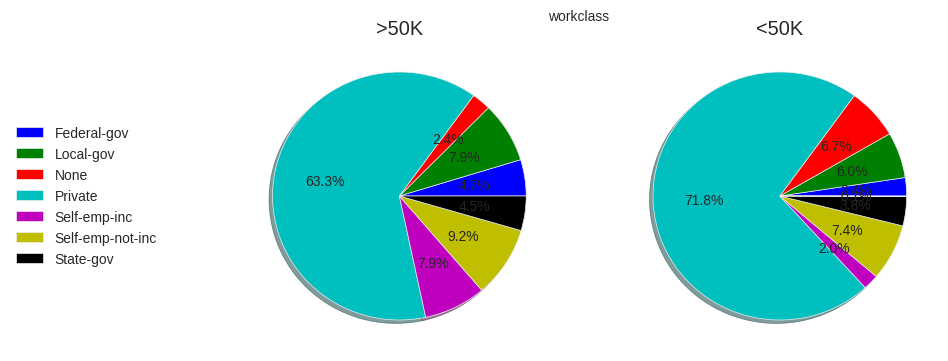

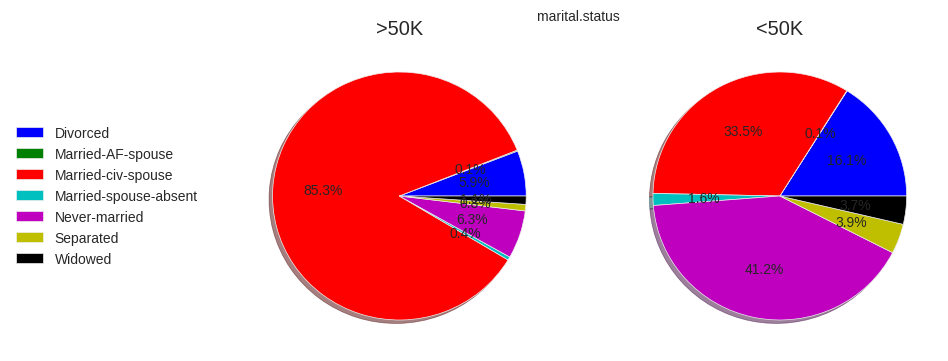

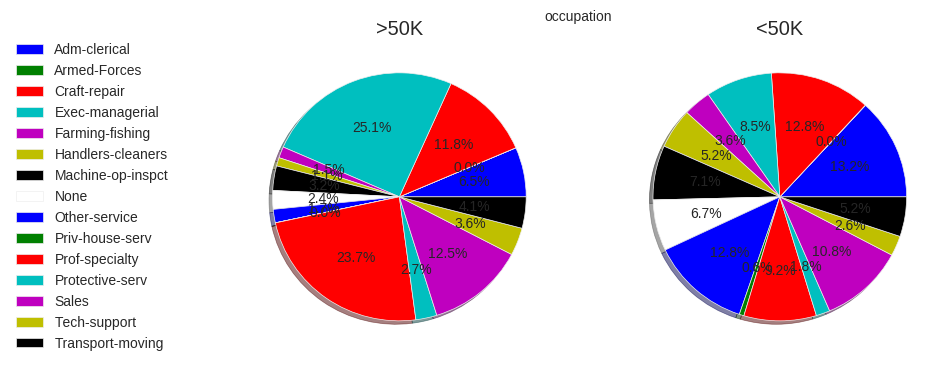

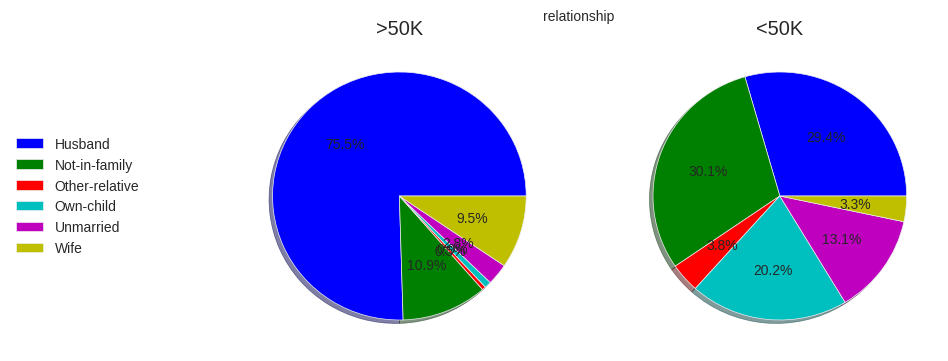

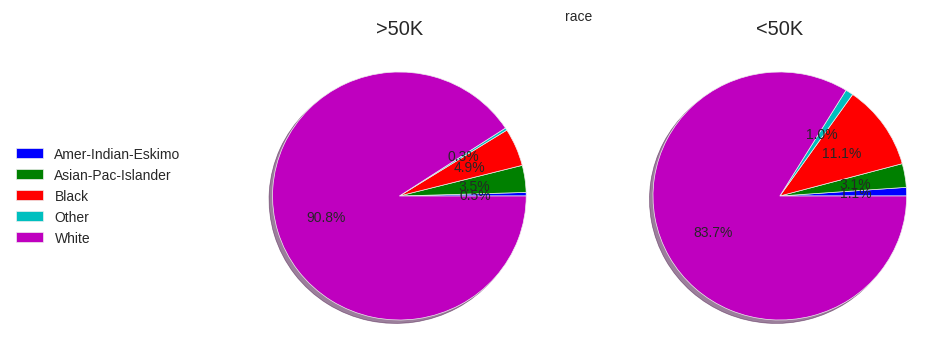

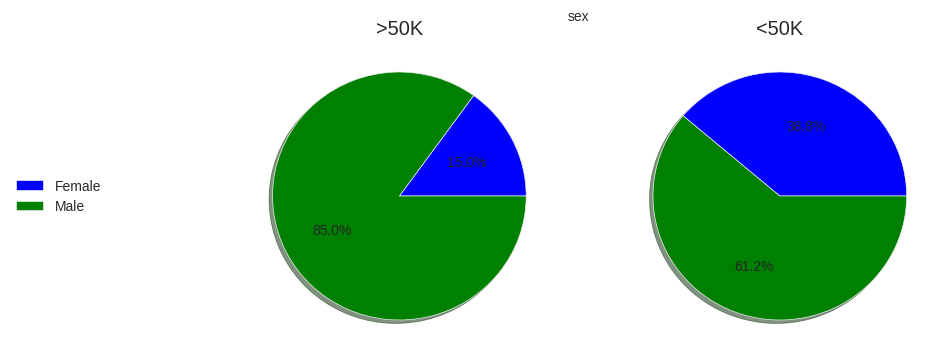

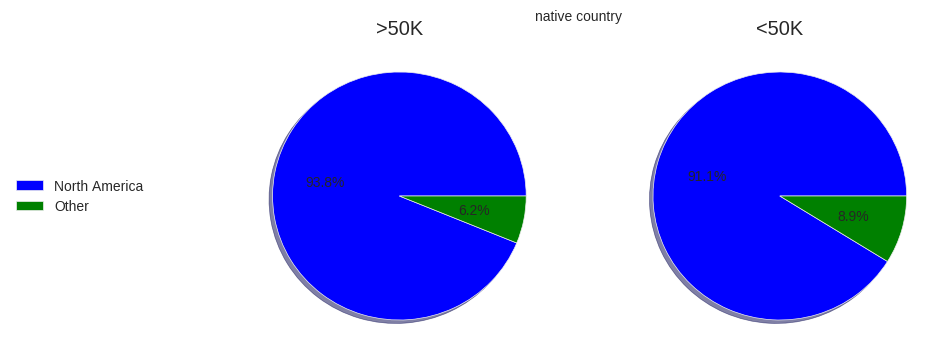

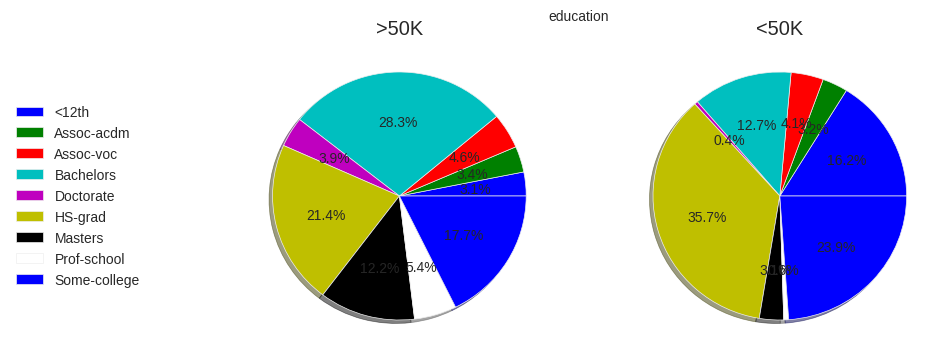

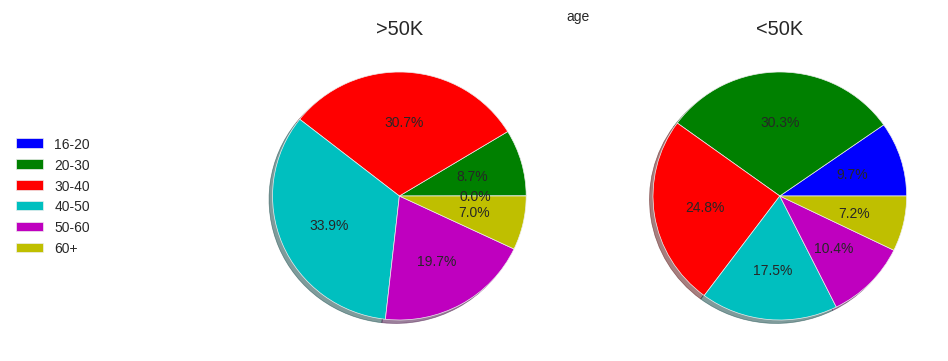

In [13]:
from matplotlib import gridspec

def plotpair(title, series1, series2):
    plt.figure(figsize=(9,4))
    plt.suptitle(title)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    series = series1.value_counts()
    series = series.sort_index();
    ax1 = plt.subplot(gs[0])
    labels = [""]*len(series)
    #labels = series.index
    ax1.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
    labels = series.index
    ax1.legend(loc='center left', shadow=True, bbox_to_anchor=(-0.75, 0.5), labels=labels)
    ax1.xaxis.set_visible(False)
    ax1.set_title(">50K")

    series = series2.value_counts()
    series = series.sort_index();
    ax2 = plt.subplot(gs[1])
    labels = [""]*len(series)
    ax2.pie(series, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
    ax2.set_title("<50K")

    plt.show()

columns = ["race", "workclass", "marital.status", "occupation", "relationship", "race", "sex"]

for x in columns:
    plotpair(x, adult.loc[adult["income"] == ">50K"][x], adult.loc[adult["income"] != ">50K"][x])
    
df1 = adult.copy()
df1.loc[df1["native.country"] != "North America", "native.country"] = "Other"
plotpair("native country", df1.loc[df1["income"] == ">50K"]["native.country"], df1.loc[df1["income"] != ">50K"]["native.country"])

df1.loc[df1["education.num"] <= 8, "education"] = "<12th"
plotpair("education", df1.loc[df1["income"] == ">50K"]["education"], df1.loc[df1["income"] != ">50K"]["education"])


df1.loc[df1["age"] > 60, "age1"] = "60+"
df1.loc[(df1["age"] > 50) & (df1["age"] <= 60), "age1"] = "50-60"
df1.loc[(df1["age"] > 40) & (df1["age"] <= 50), "age1"] = "40-50"
df1.loc[(df1["age"] > 30) & (df1["age"] <= 40), "age1"] = "30-40"
df1.loc[(df1["age"] > 20) & (df1["age"] <= 30), "age1"] = "20-30"
df1.loc[(df1["age"] > 10) & (df1["age"] <= 20), "age1"] = "16-20"
plotpair("age", df1.loc[df1["income"] == ">50K"]["age1"], df1.loc[df1["income"] != ">50K"]["age1"])


## 3.2 Badanie korelacji

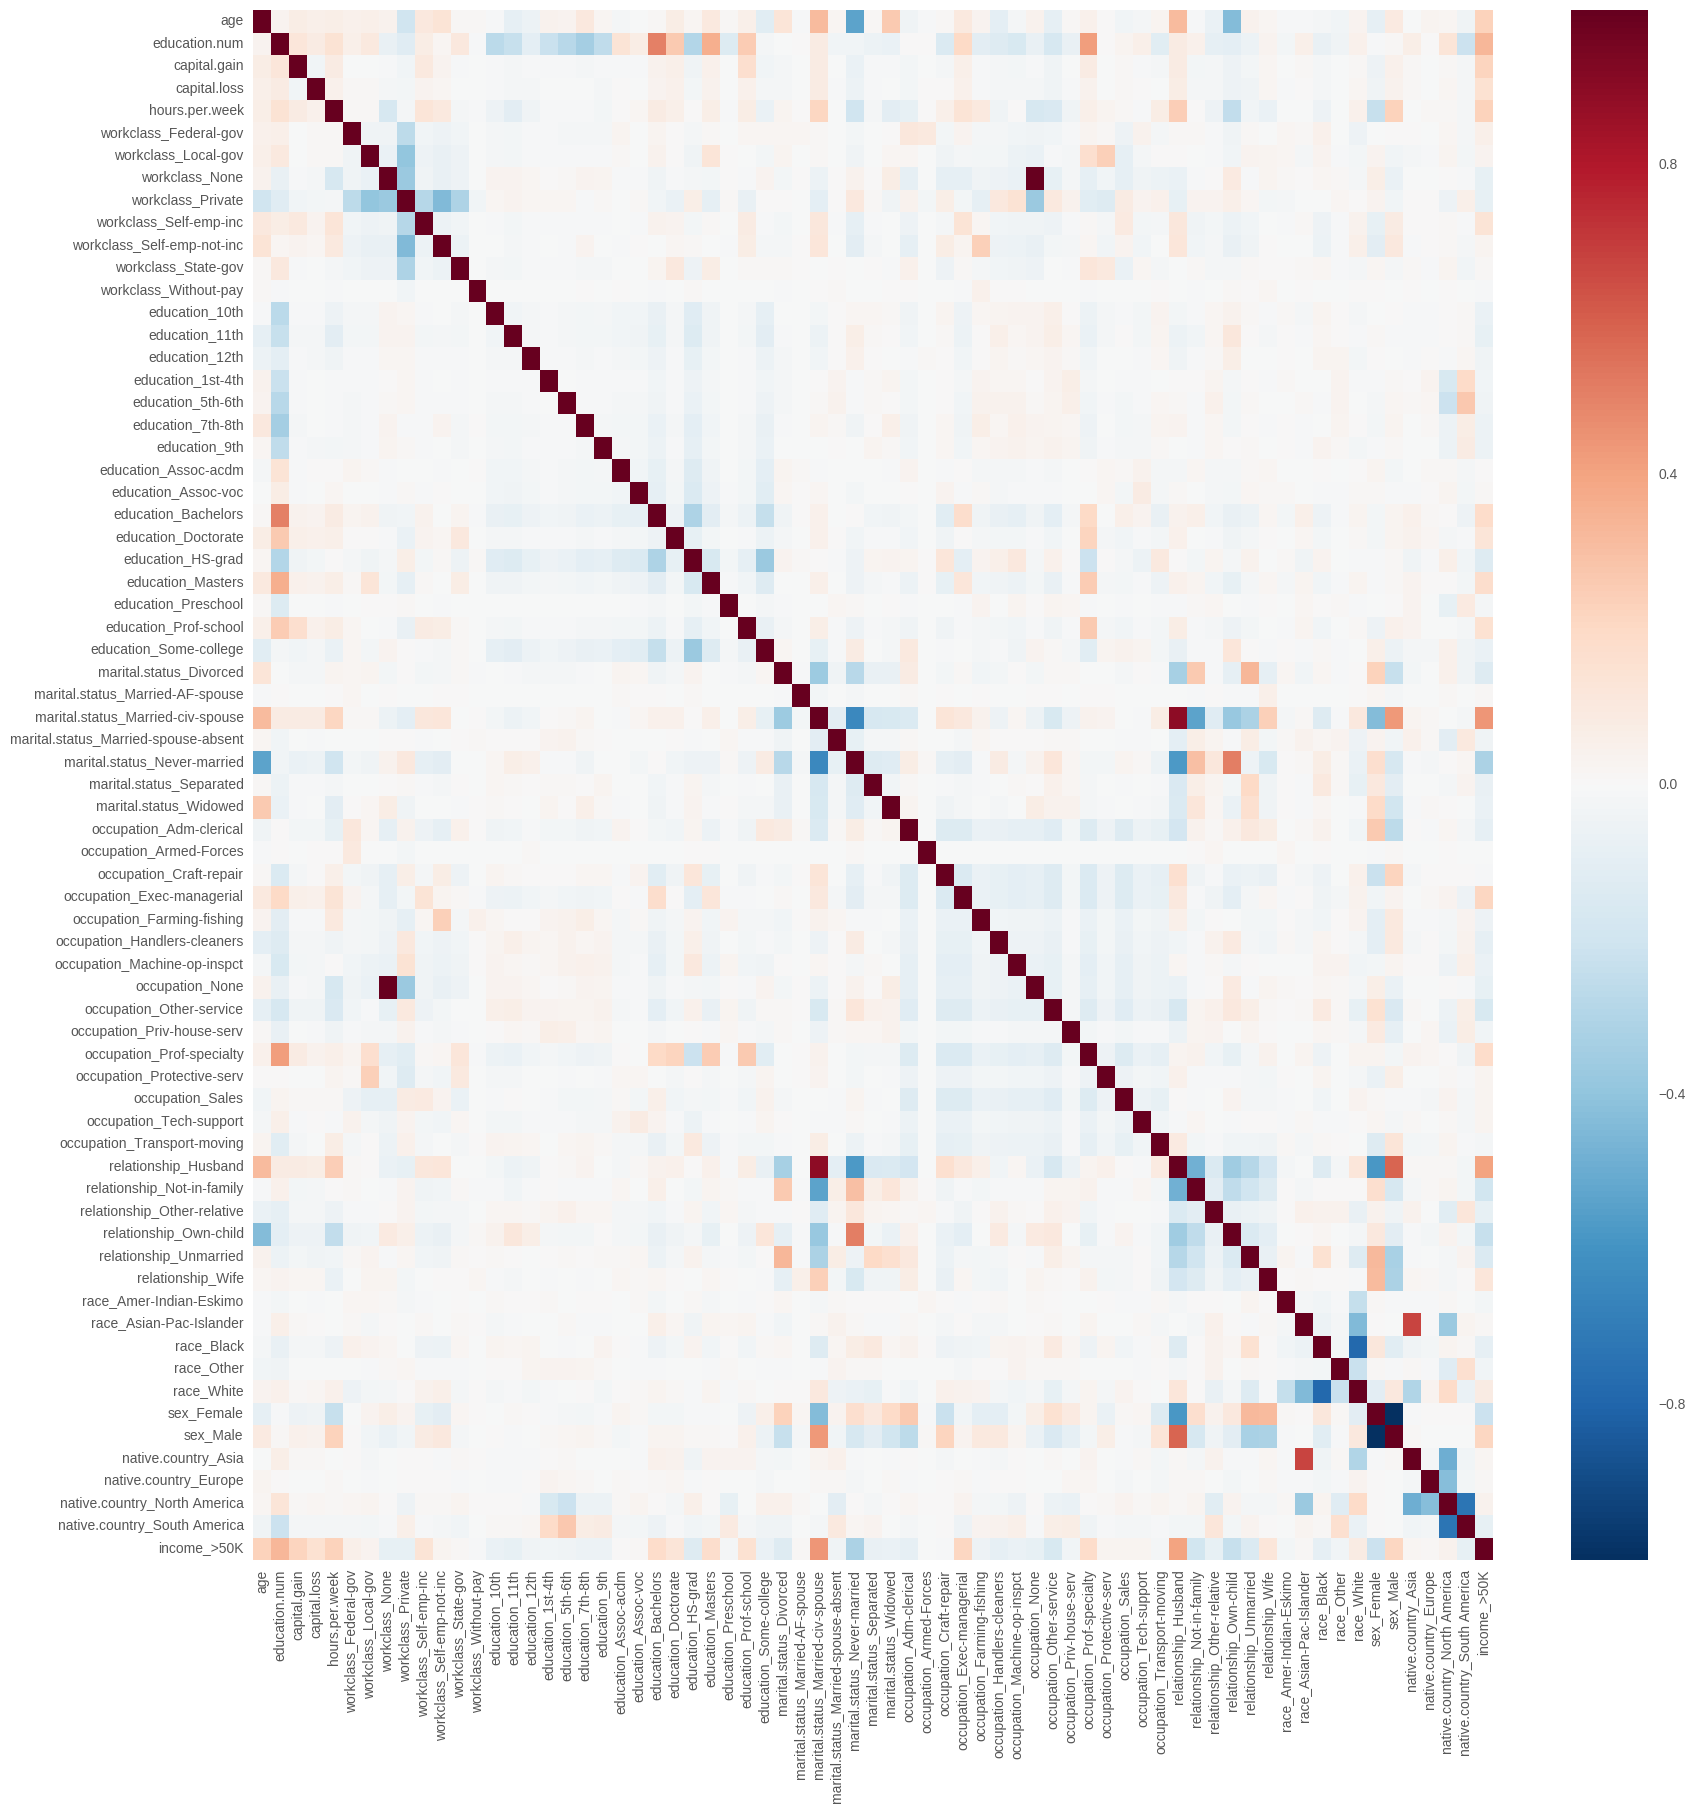

In [14]:
binary_data = pd.get_dummies(adult)
del binary_data['income_<=50K']
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr())
plt.show()

# 4. Klasyfikacja

In [31]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics

def drawCoefs(model):
    plt.figure(figsize=(15,5))
    coefs = pd.Series(model.coef_[0], index=X_train.columns)
    coefs = coefs.sort_values(ascending=False)
    coefs.plot(kind="bar")
    plt.show()
    
def drawPred(model):
    y_pred = model.predict(X_test)
    print "Błąd klasyfikacji:", 1.0-model.score(X_test,y_test)
    print metrics.classification_report(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(data=cm, columns=["Przewidywane <=50K", "Przewidywane >50K"], index=["Rzeczywiste <=50K", "Rzeczywiste >50K"])
    print df
    #print "\nMiara F: %f" % skl.metrics.f1_score(y_test, y_pred)

bd_without_income = binary_data.copy()
del bd_without_income["income_>50K"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(bd_without_income, binary_data["income_>50K"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)



## 4.1 Naiwny Baynes

In [16]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(X_train, y_train)

drawPred(nb)

Błąd klasyfikacji: 0.378724275622
             precision    recall  f1-score   support

        0.0       0.96      0.52      0.68      7420
        1.0       0.38      0.93      0.54      2347

avg / total       0.82      0.62      0.64      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                3889               3531
Rzeczywiste >50K                  168               2179


## 4.2 Drzewa Decyzyjne

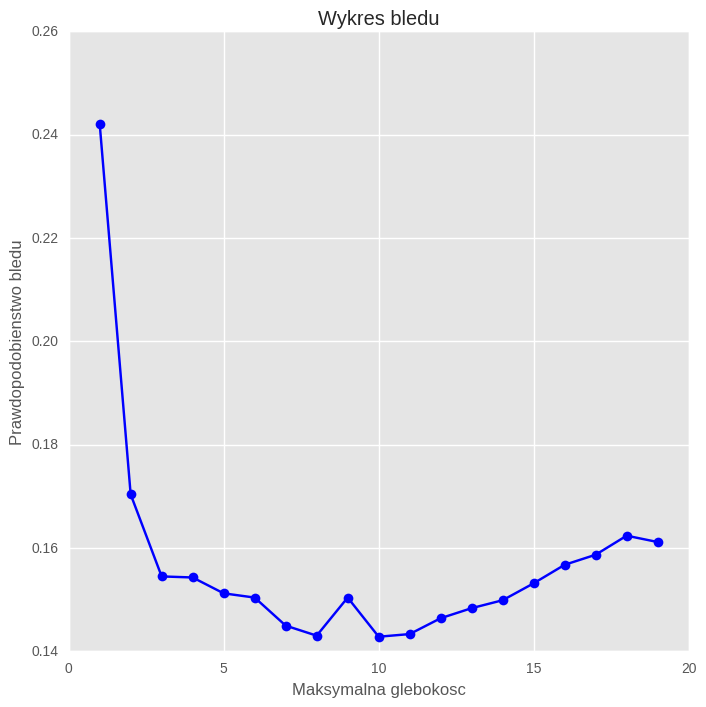

Zalecana glebokosc: 10 Błąd:  0.142827889833


In [42]:
from sklearn import tree
kvals = range(1, 20)
rss_all = np.zeros(19)
minval = 1.0
depth = 0
for k in kvals:
    mtree = tree.DecisionTreeClassifier(max_depth=k)
    mtree.fit(X_train, y_train)
    predictions = mtree.predict(X_test)
    error = 1-mtree.score(X_test,y_test)    
    rss_all[k-1] = error
    if error < minval:
        minval = error
        depth = k
plt.figure(figsize=(8,8))
plt.plot(kvals, rss_all,'bo-')
plt.title('Wykres bledu')
plt.xlabel(u'Maksymalna glebokosc')
plt.ylabel('Prawdopodobienstwo bledu')
plt.show()

print 'Zalecana glebokosc:', depth, 'Błąd: ', minval

In [43]:
from sklearn import tree

mtree = tree.DecisionTreeClassifier(max_depth=depth)
mtree.fit(X_train, y_train)

drawPred(mtree)

Błąd klasyfikacji: 0.142725504249
             precision    recall  f1-score   support

        0.0       0.87      0.95      0.91      7402
        1.0       0.80      0.55      0.65      2365

avg / total       0.85      0.86      0.85      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                7068                334
Rzeczywiste >50K                 1060               1305


## 4.3 Metoda najbliższych sąsiadów

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)

drawPred(knn)

Błąd klasyfikacji: 0.174465035323
             precision    recall  f1-score   support

        0.0       0.85      0.94      0.89      7420
        1.0       0.71      0.46      0.56      2347

avg / total       0.81      0.83      0.81      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                6973                447
Rzeczywiste >50K                 1257               1090


Bardzo powolne obliczenia wywołane obszernością tablicy. Nieefektywna dla tego problemu.

## 4.3 Regresja logistyczyczna

In [20]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)

drawPred(cls)

Błąd klasyfikacji: 0.147844783454
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.91      7420
        1.0       0.73      0.60      0.66      2347

avg / total       0.85      0.85      0.85      9767

                   Przewidywane <=50K  Przewidywane >50K
Rzeczywiste <=50K                6906                514
Rzeczywiste >50K                  930               1417


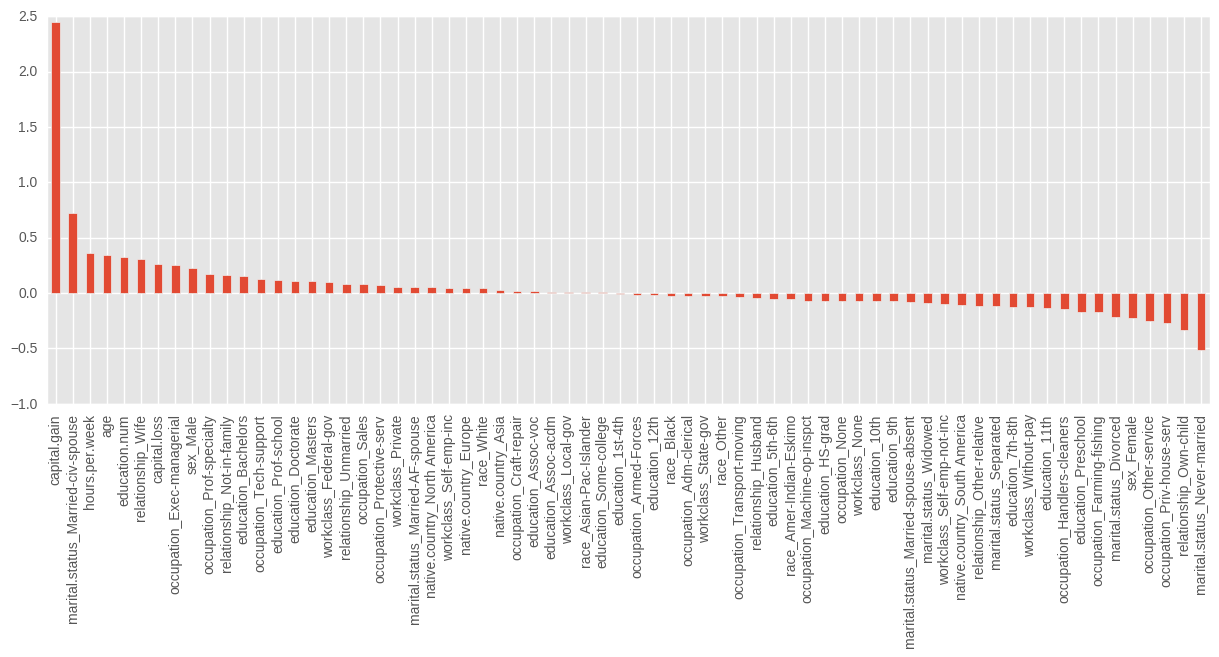

In [32]:
drawCoefs(cls)

# 5. Podsumowanie

In [ ]:
adult

In [ ]:
[float(x)/2 for x in range(5)]